In [125]:
%matplotlib inline
from matplotlib import pyplot as plt
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec 

from astropy.io import fits
from astropy import units as u
from astropy import modeling
from astropy.table import Table

from astropy import modeling
from astropy import constants as cnst

## General Procedure
#### Overscan/Bias
#### Small Scale Flat
#### Combine exposures
#### Sky subtration
#### Extract Target Spectrum & collapse to 1D

How to use this pipeline for Dispersion Solution:

1. define ALL files to be used in reduction (see example for list)
2. set specset = dispersion fcn to use in guess_plot
3. use dispersion outputted graphs to estimate wl & pixel matches
4. use guess_plot to get linelist matches to refine pixel estimates 
5. collect ~5 of these in lists
6. use goodness_of_matches to populate more matches based on inital guesses & plot residuals
7. if satisfied, set ds = goodness_of_matches; this is the dispersion solution now

How to extract 1D Spectrum of Target---for each side!
1. define a targetID & skyaps
2. run sky_subtract and refine skyaps based on first graph produced
3. if satisfied set flux, unc = sky_subtract; this is the target's 1D flux spectrum for that side

How to combine red & blue sides to get one complete target spectrum
1. working on it

In [126]:
def guess_plot(pxguess, wlguess, specset, pxwindw=300, wlwindow=400): 
    fig, (ax1, ax2) = plt.subplots(1,2)

    ds, wlatlas, specatlas, linelist = specset 
    
    #use these graphs to refine matching of arcs to atlas
    
    #first graph 
    plt.axes(ax1)
    ds.plot_spec() #1D spectrum of dispersion solution or is this the arc..waiting on eriks answer
    plt.axvline(pxguess, color='k', ls=':') #plot a vertical line where think peak pixel is in emission lines
    plt.xlim(pxguess-pxwindw/2, pxguess+pxwindw/2)
    #plt.ylim(0, np.max(ds.spec1d[plt.xlim()[0] : plt.xlim()[1]])*1.05)
    plt.title('DS 1D Spectrum')

    
    #second graph
    plt.axes(ax2)
    plt.plot(wlatlas, specatlas) #plots what atlas spectrum looks like
    plt.title('Atlas 1D Spectrum')
    plt.axvline(wlguess, color='k', ls=':')
    plt.xlim(wlguess-wlwindow/2, wlguess+wlwindow/2)
    
    #defs the min & max wavelength peaks to use to scale in next lines
    minpx = np.argmin(np.abs(wlatlas-(wlguess-wlwindow/2)))
    maxpx = np.argmin(np.abs(wlatlas-(wlguess+wlwindow/2)))
    
  
    
    #sets wavelength scales based on graph size-ish
    plt.ylim(0, specatlas[minpx:maxpx].max()*1.05)
    guess = reduce_dblspec.nearest_in_line_list(wlguess, linelist)
    plt.axvline(guess[0], color='r', ls=':') #for 1st wavelength to linelist match draw red vertical line
    
    return guess #outputs wavelength guesses based on atlas spec known linelists

In [127]:
def dispersion(all_side_files,atlasfiles,arcfiles,linelist):
    #Overscan the flats
    flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat',all_side_files)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
    #note above only works if all output headers include 'DomeFlat'
    
    #small scale flat creationg - normalized
    nfl = reduce_dblspec.create_normalized_flat(flats)

    header = atlasfiles[0].header    
    specnoao = atlasfiles[0].data
    wlnoao = header['CRVAL1'] + header['CD1_1']*(np.arange(len(specnoao)) - header['CRPIX1'] + 1) #+1 is for 0-based

    #creating dispersion solution
    ds = reduce_dblspec.DispersionSolution(reduce_dblspec.DoubleSpecImage(arcfiles).overscan_sub_and_trim().flatten(nfl), (320, 360))
    
    #print(header['IRAFNAME']) 
    
    #outputs graphs of atlas
    plt.figure(figsize=(20,5))
    plt.plot(wlnoao, specnoao)
    plt.title('Atlas 1D Spectrum-wavelengths')
    plt.xlabel('wavelengths')
    #atlas plot axis range limit choices
    if header['IRAFNAME']=='henear.spec': #redside
        #print('red') #tested & worked
        print('atlas plot limits for Red side')
        plt.xlim(5000,10000)
    elif header['IRAFNAME']=='FeAr.spec': #blueside
        #print('blue') #tested & worked
        print('atlas plot limits for Blue side')
        plt.xlim(3000,5500)
        plt.ylim(0,5e5) #how to make this more flexible?
    else: #not sure why this prints for redside b/c its still choosing the correct xrange&blue does too
        print("can't determine camera side for atlas plot limits based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")    
    
    #outputting arc graph so can guess lines
    plt.figure(figsize=(20,5))
    plt.xlabel('pixels')
    plt.title('Arc Lamp 1D Spectrum-pixels')
    ds.plot_spec()
    #extra condition just for blue side orientation b/c of camera inversion to make comparison to atlas easier
    if header['IRAFNAME']=='FeAr.spec': #blueside
        plt.xlim([2800,0]) #for arc
    
    specset = (ds, wlnoao, specnoao,linelist)
    return (specset) #returns input for guess_plot along with graphs to make pixel & wl guesses

In [128]:
def goodness_of_matches(arcfiles, guesses,all_side_files, atlasfiles,linelist):
    flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat',all_side_files)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
    #note above only works if all output headers include 'DomeFlat'
    #outputs = []
    #small scale flat creationg - normalized
    nfl = reduce_dblspec.create_normalized_flat(flats)
    header = atlasfiles[0].header    
    
    arcimg = reduce_dblspec.DoubleSpecImage(arcfiles).overscan_sub_and_trim().flatten(nfl)
    
    #print(header['IRAFNAME'])
    if header['IRAFNAME']=='henear.spec': #redside
        print('chose ds for redside')
        ds = reduce_dblspec.DispersionSolution(arcimg, (320, 360), poly_order=3)
        #print('ds for red')
    elif header['IRAFNAME']=='FeAr.spec': #blueside
        print('chose ds for blueside')
        ds = reduce_dblspec.DispersionSolution(arcimg, (205, 260), poly_order=3)
    else:#for some reason this prints AS WELL AS prints indicating red side choosen for red side only, blue works fine
        print("camera side for ds not understood based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")


    
    outputs = []
    for i in guesses:
            list_a = ds.guess_line_loc(i[0], i[1]) #guesses(pixel, wl)
            outputs.append(list_a) #why am i collecting these? where are they used?
            
    #print(header['IRAFNAME'])
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('chose guesses for blueside')
        ds.guess_from_line_list(linelist,minpeakratio=5, continuous_fit=True, sigmaclip=True, max_wl=5400)    
    elif header['IRAFNAME']=='henear.spec': #redside
        print('chose guesses for redside')
        ds.guess_from_line_list(linelist,minpeakratio=10, continuous_fit=True, sigmaclip=True, min_wl=5600)
    else:
        print("camera side for guesses not understood based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")
        #ds.guess_from_line_list(linelist,minpeakratio=10, continuous_fit=True, sigmaclip=True, min_wl=3000)
    



    #1st graph-residuals
    plt.figure(figsize=(20,5))
    residuals = ds.plot_solution(True)  
    #2nd graph-populated matches, px to wl;want linear 
    plt.figure(figsize=(20,5))
    ds.plot_spec_wl()
    
    return (ds) 

In [129]:
#skyaps=[(lower bound pixel location in (x,y), upper bound pixel location in (x,y))]
#play with vmax & vmin to get better contrast
def sky_subtract(targetID,skyaps,ds,all_side_files,atlasfiles):
    #need these again -flats/overscan
    flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat',all_side_files)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
    nfl = reduce_dblspec.create_normalized_flat(flats)
    
    header = atlasfiles[0].header    


    
    #locating all files w/ the target & flat/overscan subt
    specs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(nfl) 
          for fn in reduce_dblspec.find_all_obj(targetID,all_side_files)]
    
    
    print(len(specs))


    
    
    #stacking all that data for specific target-help increase s/n 
    comb = reduce_dblspec.combine_imgs(specs)
    
    
    
    
    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(20,10)) #setting up fig size
    subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0))
    plt.subplot(211)
    plt.title('2D spec - Verify skyaps for correct target extraction')
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('choose 2D spec for blueside')
        subimg.show_image(transpose=True,vmax=40,vmin=-10)
    elif header['IRAFNAME']=='henear.spec': #redside
        print('choose 2D spec for redside')
        subimg.show_image(transpose=False,vmax=40,vmin=-10) 
    else:
        print("camera side for 2D spec not understood based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")    
    
    
    #setting up 1D extraction of target
    #setting up extraction range based on sky apps not sure if these is good to do b/c depends on extension of gal size
    begin = (skyaps[0][0] + 60)
    print ('this is beginning value of target spec extraction:',begin)
    end = (skyaps[1][0] - 30)
    print('this is end value of target spec extraction:',end)
    flux, unc = subimg.extract_spectrum((begin,end))
    
    #plotting 1D extraction of target
    plt.subplot(212)
    plt.step(ds.pixtowl(np.arange(len(flux))), flux)
    plt.title('1D Target Spectrum')
    plt.ylabel('flux -- but ask Erik to be sure (counts/units?)')
    plt.xlabel('wavelength')
    #based below limit choices on info on palomar dblspec webpage
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('choose 1D target spec axis limits for blueside')
        plt.xlim(2800, 7000) #3600,5800 
        plt.ylim(0, plt.ylim()[-1])
    elif header['IRAFNAME']=='henear.spec': #redside
        print('choose 1D target spec axis limits for redside')
        plt.xlim(4700, 11000)
        plt.ylim(0, plt.ylim()[-1])

    
    return (flux, unc)


In [130]:
def combine_red_blue(ds_red,ds_blue,flux_red,flux_blue):
    wl = np.append(ds_red.pixtowl(np.arange(len(flux_red))), ds_blue.pixtowl(np.arange(len(flux_blue))))
    
    red_and_blue_flux = np.append(flux_red,flux_blue)
    plt.step(wl, red_and_blue_flux)
    plt.xlabel('wavelength')
    plt.ylabel('?? flux??')
    plt.title('1D Spectrum for Target')
    plt.ylim(0, max(red_and_blue_flux)) #ok to be 0? ?b/c of negative flux values but thats odd itself..
    return(red_and_blue_flux)

In [131]:
#def trace(targetID,skyaps,ds,all_side_files,atlasfiles):
    

Collecting problems to debug:
1. list error for OBrother_nospec when running dispersion

Collecting questions:
1. for flats in dispersion do wanna only use 10?
2. what to do with overlap b/c wl's dont match to add. tried a few ways with averaging but better to get more guidance


**_Directory of Main Sections_**
- DS - RED 1.5"
- DS - RED 1.0"
- DS - BLUE 1.5"
- DS - BLUE 1.0"
- SKY SUBTRACTION FOR TARGET: M-01-04 (BLUE 1.0", RED 1.0")
- SKY SUBTRACTION & R/B SIDE COMBINATION FOR TARGET: ODY_NOSPEC (RED 1.5", BLUE 1.5")

# EXAMPLE: Red (1.5") -- dispersion solution
### Running data pipeline to generate graphs for wl & pixel  emission line matching

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


atlas plot limits for Red side


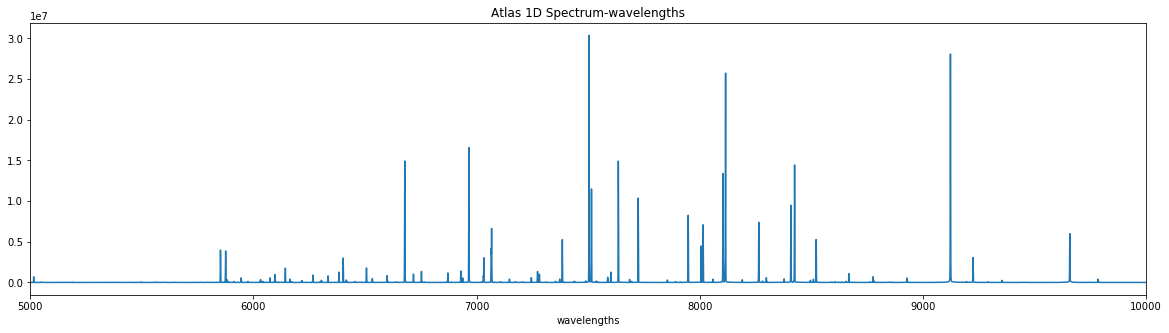

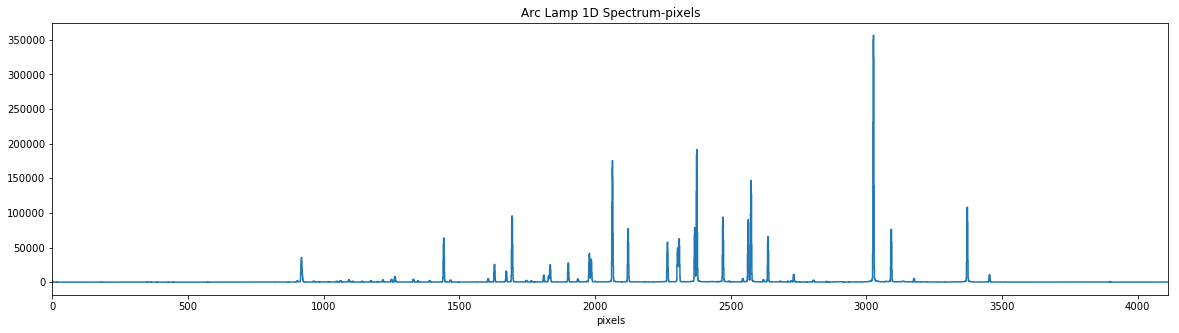

In [132]:
#running data pipeline to generate graphs for wl & pixel matching

#nameing all the datafiles needed
all_side_files_red15 = '20170518/red*.fits' #redside
atlasfiles_red15 = fits.open('henear.fits') #NOAO atlas #redside
arcfiles_red15 = '20170518/red0017.fits' #redside
linelist_red15 = reduce_dblspec.HENEAR_LINE_LIST #must be in this form cant use'henearhres.dat'-debug later

#naming pipeline output for guess_plot use
specset_red15 = dispersion(all_side_files_red15, atlasfiles_red15, arcfiles_red15, linelist_red15)

### Collecting guesses from graphs above - manual intervention part

(9122.9673999999995, '9122.9674    ArI')

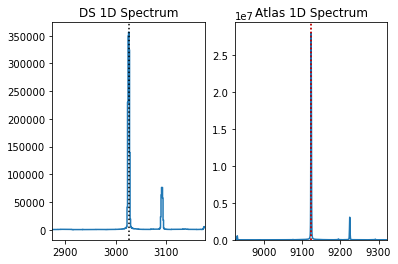

In [133]:
#guessing matching lines from above graphs
#entering (px,wl)guesses & data
guess_plot(3025.5,9122.9674,specset_red15) #outputs (pixel guess, nearest wl/id in linelist)

In [134]:
#collect guesses here ~5 seems good
pixel_guesses_red15 = [3372,3027,2375,2065,1630]
atlas_lines_red15 = [9657.78,9122.9674,8115.31,7635.1,6965.43]

guesses_red15 = list(zip(pixel_guesses_red15, atlas_lines_red15)) #making tuples to pass into fcn later

### Using goodness_of_matches to generate residuals and more line matches based on guesses above

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Failed to find line KrI at wl=7854.8215: "Guessed line's peak to base ratio is 0.8644155931496915, which is less than 10"
Failed to find line ArI at wl=7891.075: "Guessed line's peak to base ratio is 0.9941144590061228, which is less than 10"
Failed to find line KrI at wl=7913.4242: "Guessed line's peak to base ratio is 1.0229280821470732, which is less than 10"
Found line ArI at wl=7948.1764
Clipped 0 lines
Failed to find line ArI at wl=8006.1567: "Guessed line's peak to base ratio is 4.148138032795113, which is less than 10"
Failed to find line ArI at wl=8014.7857: "Guessed line's peak to base ratio is 3.3988140467662045, which is less than 10"
Failed to find line KrI at wl=8059.5038: "Guessed line's peak to base ratio is 0.9784268022083137, which is less than 10"
Found line ArI at wl=8103.6931
Clipped 0 lines
Found line ArI at wl=8115.311
Clipped 0 lines
Failed to find line KrI at wl=8190.0543: "Tried to find peak at 2422.9794134689537 but it's in a valley, not a peak"
Found line Ar

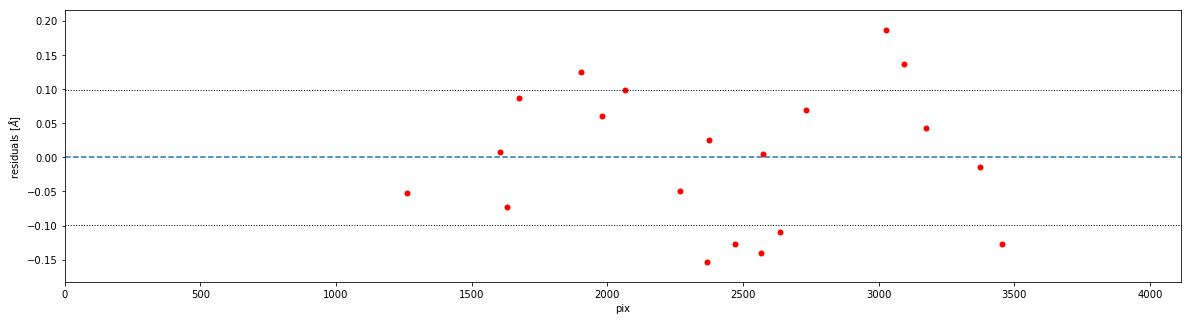

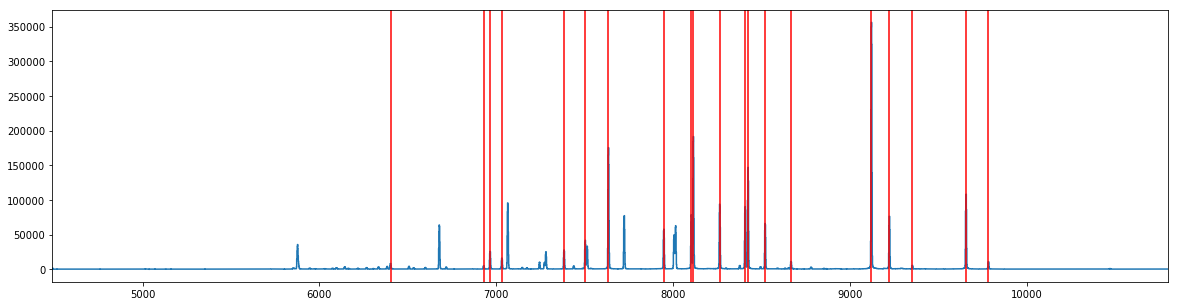

In [135]:
ds_red15 = goodness_of_matches(arcfiles_red15,guesses_red15,all_side_files_red15,atlasfiles_red15,linelist_red15)

# Red (1.0") --dispersion solution

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


atlas plot limits for Red side


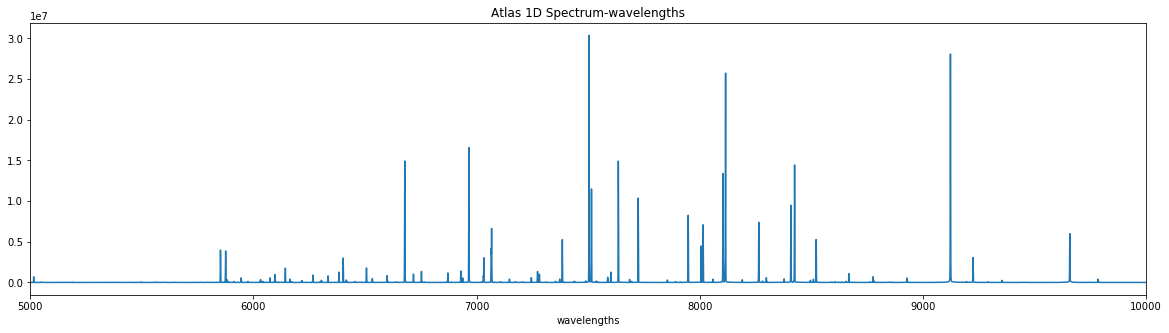

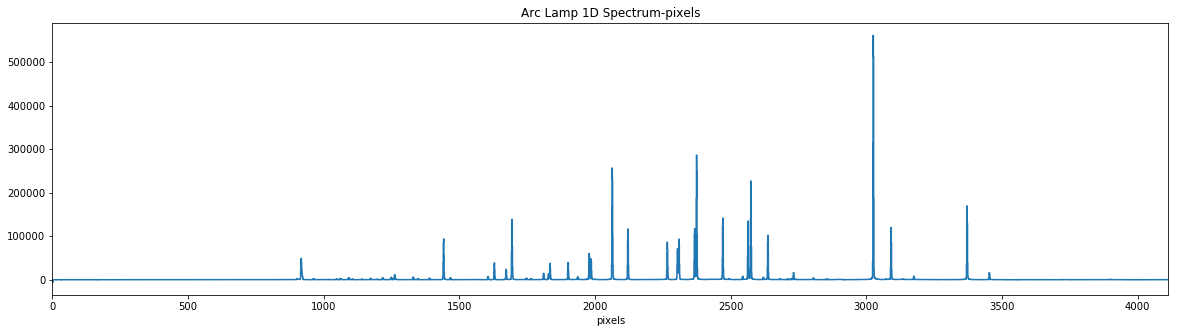

In [136]:
#nameing all the datafiles needed
all_side_files_red10 = '20170518/red*.fits' #redside
atlasfiles_red10 = fits.open('henear.fits') #NOAO atlas #redside
arcfiles_red10 = '20170518/red0012.fits' #redside
linelist_red10 = reduce_dblspec.HENEAR_LINE_LIST

specset_red10 = dispersion(all_side_files_red10, atlasfiles_red10, arcfiles_red10, linelist_red10)

(9657.7862999999998, '9657.7863    ArI')

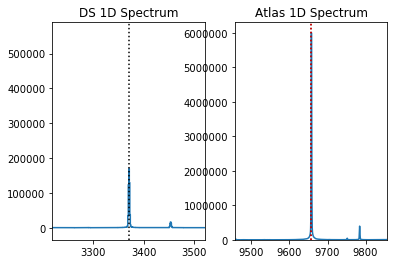

In [137]:
#guessing matching lines from above graphs
#entering (px,wl)guesses & data
guess_plot(3370,9657,specset_red10) #outputs (pixel guess, nearest wl/id in linelist)

In [138]:
#collect guesses here ~5 seems good
pixel_guesses_red10 = [3024,2373,2062,1672,3370]
atlas_lines_red10 = [9122.9674,8115.311,7635.106,7032.4131,9657.7863]

guesses_red10 = list(zip(pixel_guesses_red10, atlas_lines_red10)) #making tuples to pass into fcn later

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Failed to find line NeI at wl=7544.0443: "Guessed line's peak to base ratio is 1.2925552080633658, which is less than 10"
Failed to find line KrI at wl=7587.413: "Guessed line's peak to base ratio is 1.0819554378142586, which is less than 10"
Failed to find line KrI at wl=7601.5443: "Guessed line's peak to base ratio is 1.0525916052067257, which is less than 10"
Found line ArI at wl=7635.106
Clipped 0 lines
Failed to find line KrI at wl=7685.246: "Tried to find peak at 2095.7102377360125 but it's in a valley, not a peak"
Failed to find line KrI at wl=7694.5393: "Guessed line's peak to base ratio is 0.9487211223641862, which is less than 10"
Failed to find line KrI at wl=7854.8215: "Guessed line's peak to base ratio is 1.1041302787798228, which is less than 10"
Failed to find line ArI at wl=7891.075: "Guessed line's peak to base ratio is 1.1153847553894787, which is less than 10"
Failed to find line KrI at wl=7913.4242: "Tried to find peak at 2243.4658680624693 but it's in a valley, not

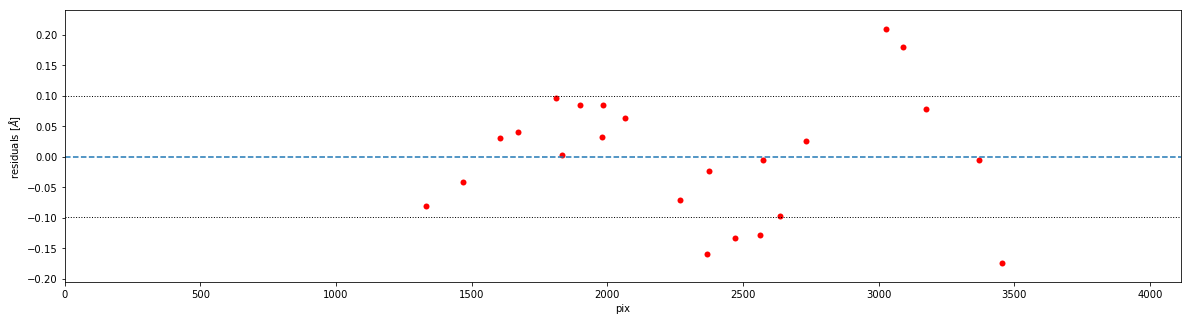

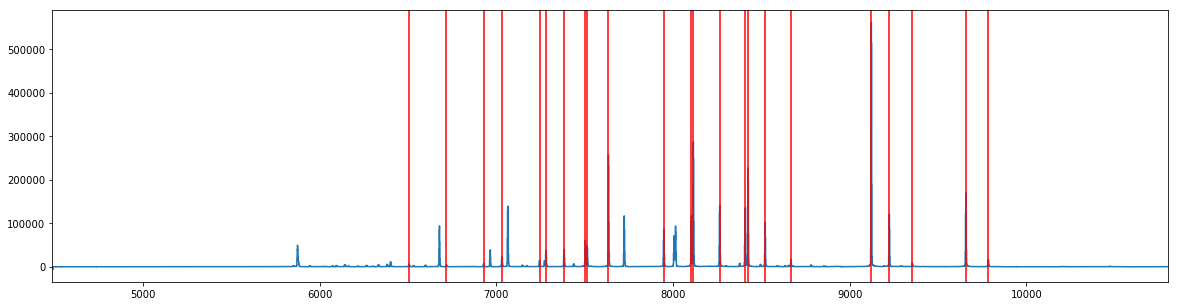

In [139]:
ds_red10 = goodness_of_matches(arcfiles_red10,guesses_red10,all_side_files_red10,atlasfiles_red10,linelist_red10)

# Blue (1.5") --dispersion solution

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


atlas plot limits for Blue side
not sure how to get around inverting arc blue cam side to look similar to atlas 1D spec...
b/c when use guess plot it appears in original orientation (which can be confusing at first)


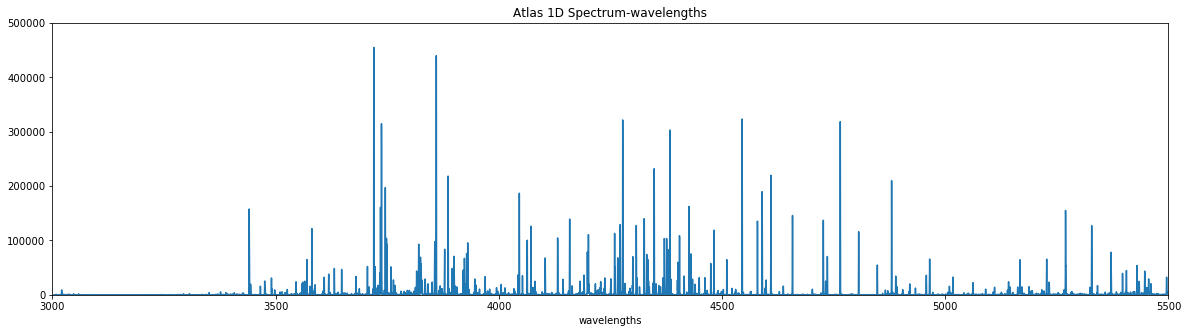

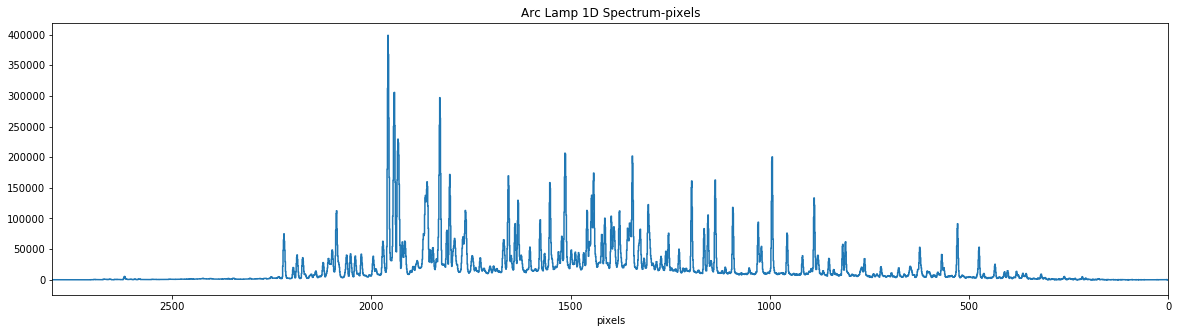

In [140]:
all_side_files_blue15 = '20170518/blue*.fits' #blueside
atlasfiles_blue15 = fits.open('fear.fits') #NOAO atlas #blueside
arcfiles_blue15 = '20170518/blue0018.fits' #blueside
linelist_blue15 = reduce_dblspec.FEAR_LINE_LIST #must be in this form cant use'fear.dat'--debug later

specset_blue15 = dispersion(all_side_files_blue15, atlasfiles_blue15, arcfiles_blue15, linelist_blue15)


print ('not sure how to get around inverting arc blue cam side to look similar to atlas 1D spec...''\n'
       'b/c when use guess plot it appears in original orientation (which can be confusing at first)')

(3581.1925000000001, '3581.1925  FeI')

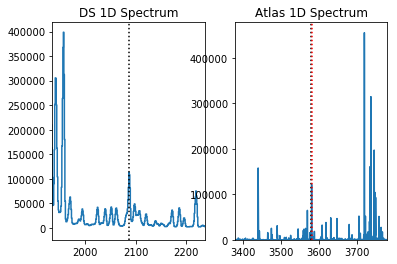

In [141]:
guess_plot(2086,3580,specset_blue15) #(px,wl)

In [142]:
#collect guesses here
pixel_guesses_blue15 = [529,993,1655,1956,2086]
atlas_lines_blue15 = [5269.5366,4764.8646,4044.4179,3719.9346,3581.1925] 

guesses_blue15 = list(zip(pixel_guesses_blue15, atlas_lines_blue15)) #making tuples to pass into fcn later

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for blueside
chose guesses for blueside
Failed to find line FeI at wl=3020.6391: "Guessed line's peak to base ratio is 0.7312268222798526, which is less than 5"
Failed to find line FeI at wl=3024.0325: "Guessed line's peak to base ratio is 3.6415429388607117, which is less than 5"
Failed to find line FeI at wl=3037.3887: "Guessed line's peak to base ratio is 1.046308359334491, which is less than 5"
Failed to find line FeI at wl=3047.6043: "Tried to find peak at 2599.234585866781 but it's in a valley, not a peak"
Failed to find line FeI at wl=3057.4456: "Guessed line's peak to base ratio is 0.9892623976573754, which is less than 5"
Failed to find line FeI at wl=3059.0856: "Guessed line's peak to base ratio is 1.1518908065824378, which is less than 5"
Failed to find line FeI at wl=3225.785: "Guessed line's peak to base ratio is 1.4385738518614017, which is less than 5"
Failed to find line ArII at wl=3243.6887: "Guessed line's peak to base ratio is 1.1305223236157673, which is le

Failed to find line FeI at wl=3969.257: "Guessed line's peak to base ratio is 3.0855129661199157, which is less than 5"
Failed to find line ArII at wl=3979.3559: "Guessed line's peak to base ratio is 1.510408904251333, which is less than 5"
Failed to find line ArII at wl=3994.7918: "Guessed line's peak to base ratio is 2.4564854683248716, which is less than 5"
Failed to find line FeI at wl=4005.2414: "Guessed line's peak to base ratio is 2.333333336877587, which is less than 5"
Failed to find line ArII at wl=4033.8093: "Guessed line's peak to base ratio is 3.3812548441217003, which is less than 5"
Found line ArII at wl=4042.8937
Clipped 0 lines
Found line ArI at wl=4044.4179
Clipped 0 lines
Found line FeI at wl=4045.813
Clipped 0 lines
Failed to find line ArII at wl=4052.9208: "Guessed line's peak to base ratio is 1.4787332773721624, which is less than 5"
Failed to find line FeI at wl=4063.5939: "Guessed line's peak to base ratio is 4.627867776925382, which is less than 5"
Failed to fi

Found line ArII at wl=4764.8646
Clipped 0 lines
Found line ArII at wl=4806.0205
Clipped 0 lines
Found line ArII at wl=4847.8095
Clipped 0 lines
Failed to find line FeI at wl=4859.7406: "Guessed line's peak to base ratio is 1.5342458864362543, which is less than 5"
Found line ArII at wl=4879.8635
Clipped 0 lines
Failed to find line ArII at wl=4889.0422: "Guessed line's peak to base ratio is 3.1960434069836063, which is less than 5"
Failed to find line FeI at wl=4891.4919: "Guessed line's peak to base ratio is 3.1960434069836063, which is less than 5"
Failed to find line FeI at wl=4920.5018: "Guessed line's peak to base ratio is 4.554165053396049, which is less than 5"
Failed to find line ArII at wl=4933.2091: "Guessed line's peak to base ratio is 4.379550098648989, which is less than 5"
Found line FeI at wl=4957.5966
Clipped 0 lines
Found line ArII at wl=4965.0795
Clipped 0 lines
Failed to find line ArII at wl=4972.1597: "Guessed line's peak to base ratio is 1.4705974774310648, which is

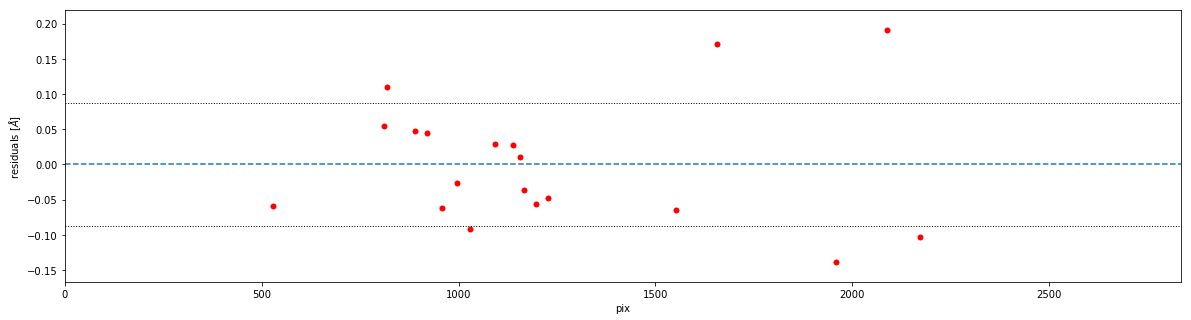

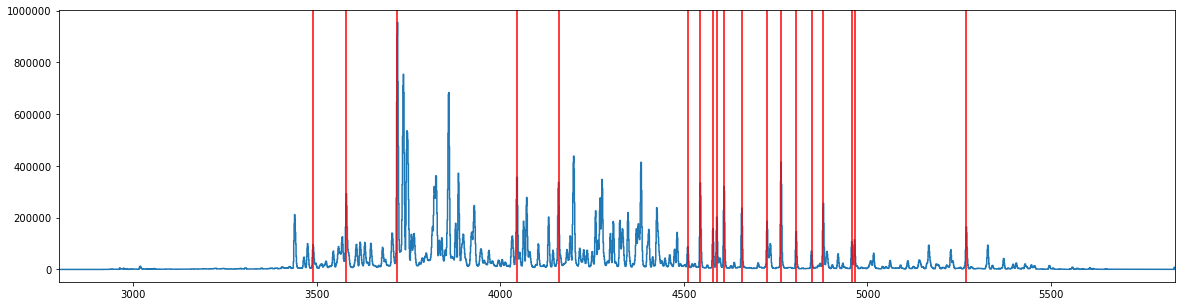

In [143]:
ds_blue15 = goodness_of_matches(arcfiles_blue15,guesses_blue15,all_side_files_blue15,atlasfiles_blue15,linelist_blue15) #yay looks good FINALLY!!
#makes sense these residuals are worse b/c just tried same guesses used for 1.0" SOOOO ds for 1.0 & 1.5 are different!


# Blue (1.0") --dispersion solution

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


atlas plot limits for Blue side
not sure how to get around inverting arc blue cam side to look similar to atlas 1D spec...
b/c when use guess plot it appears in original orientation (which can be confusing at first)


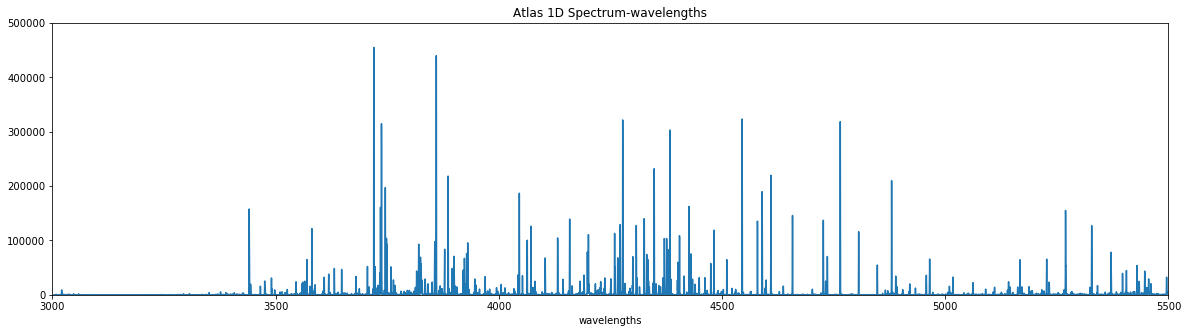

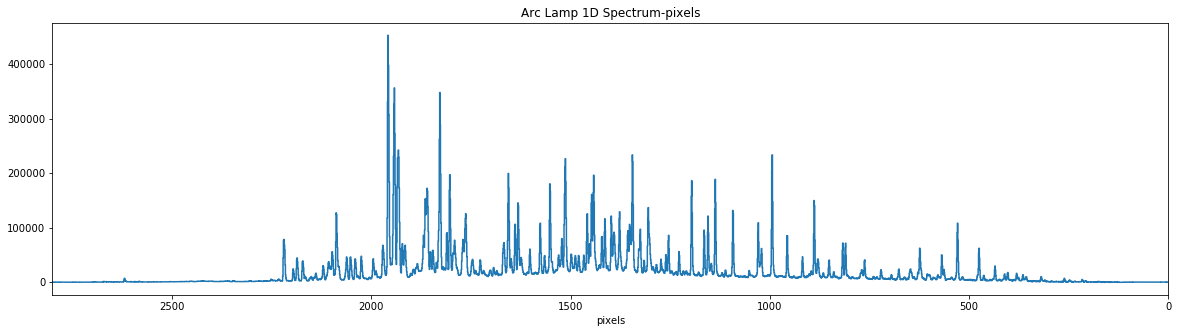

In [144]:
all_side_files_blue10 = '20170518/blue*.fits' #blueside
atlasfiles_blue10 = fits.open('fear.fits') #NOAO atlas #blueside
arcfiles_blue10 = '20170518/blue0011.fits' #blueside
linelist_blue10 = reduce_dblspec.FEAR_LINE_LIST #must be in this form cant use'fear.dat'--debug later

specset_blue10 = dispersion(all_side_files_blue10, atlasfiles_blue10, arcfiles_blue10, linelist_blue10)


print ('not sure how to get around inverting arc blue cam side to look similar to atlas 1D spec...''\n'
       'b/c when use guess plot it appears in original orientation (which can be confusing at first)')

(3581.1925000000001, '3581.1925  FeI')

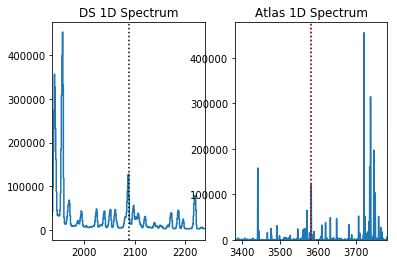

In [145]:
guess_plot(2088,3581,specset_blue10) #(px,wl)

In [146]:
#collect guesses here

pixel_guesses_blue10 = [1958,993,529,1602,1550,1254] #2088,
atlas_lines_blue10 = [3719.9346,4764.8646,5266.5546,4103.91,4158.59,4481.81] #3581.1925,
##all the commented out values either didnt allow convergence or had peak/base ratios less than 3

#these were eriks guesses....i tried different values to test method, got same results yay!
##pixel_guesses_blue10 = [1957,994,1655,1344,529] #1655,1344,1512,
##atlas_lines_blue10 = [3719.9346,4764.8646,4044.4179,4383.5445,5266.5546] #4044.4179,4383.5445,4200.6745,


guesses_blue10 = list(zip(pixel_guesses_blue10, atlas_lines_blue10)) #making tuples to pass into fcn later

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for blueside
chose guesses for blueside
Failed to find line FeI at wl=3020.6391: "Tried to find peak at 2622.141126221478 but it's in a valley, not a peak"
Failed to find line FeI at wl=3024.0325: "Guessed line's peak to base ratio is 3.884537599063041, which is less than 5"
Failed to find line FeI at wl=3037.3887: "Guessed line's peak to base ratio is 0.9729875346430994, which is less than 5"
Failed to find line FeI at wl=3047.6043: "Tried to find peak at 2595.9102217545324 but it's in a valley, not a peak"
Failed to find line FeI at wl=3057.4456: "Tried to find peak at 2586.3520807703403 but it's in a valley, not a peak"
Failed to find line FeI at wl=3059.0856: "Guessed line's peak to base ratio is 2.728611272165076, which is less than 5"
Failed to find line FeI at wl=3225.785: "Guessed line's peak to base ratio is 1.2953062119576328, which is less than 5"
Failed to find line ArII at wl=3243.6887: "Guessed line's peak to base ratio is 1.2666965744164804, which is less than 5

Failed to find line ArII at wl=3925.7188: "Guessed line's peak to base ratio is 2.3168355687893114, which is less than 5"
Failed to find line FeI at wl=3930.2962: "Guessed line's peak to base ratio is 2.3168355687893114, which is less than 5"
Failed to find line ArII at wl=3946.0971: "Guessed line's peak to base ratio is 2.6304219944069844, which is less than 5"
Failed to find line ArI at wl=3948.9789: "Guessed line's peak to base ratio is 2.6304219944069844, which is less than 5"
Failed to find line FeI at wl=3969.257: "Guessed line's peak to base ratio is 3.361028866764175, which is less than 5"
Failed to find line ArII at wl=3979.3559: "Guessed line's peak to base ratio is 1.6280945381500822, which is less than 5"
Failed to find line ArII at wl=3994.7918: "Guessed line's peak to base ratio is 2.2990012002387603, which is less than 5"
Failed to find line FeI at wl=4005.2414: "Guessed line's peak to base ratio is 2.571218523673293, which is less than 5"
Failed to find line ArII at wl=

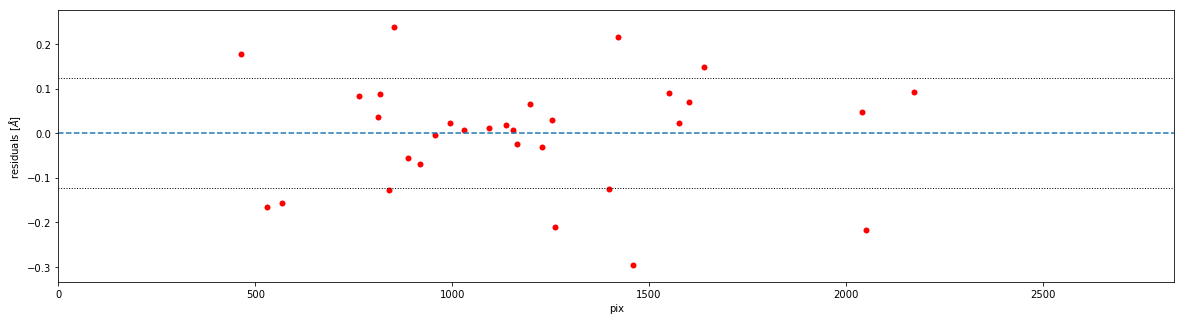

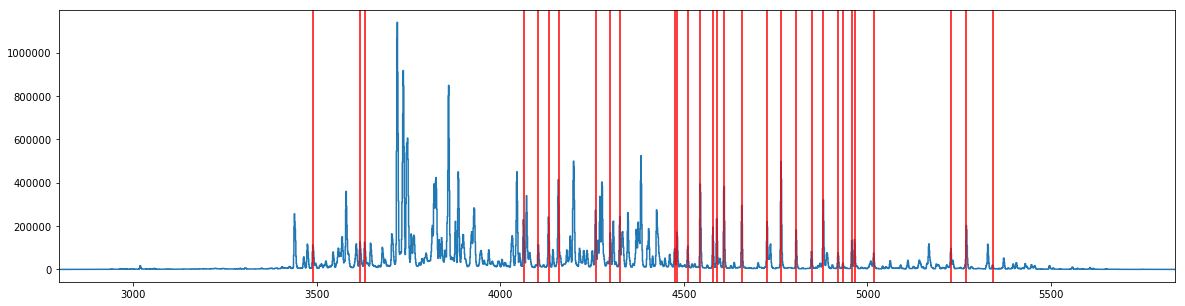

In [147]:
ds_blue10 = goodness_of_matches(arcfiles_blue10,guesses_blue10,all_side_files_blue10,atlasfiles_blue10,linelist_blue10) #yay looks good FINALLY!!
#used some guesses diff from Erik's nb BUT soln looks the same 

# Trying a Sky Subtraction on Target

# M-01-04 --Maybe dont have to do non-SAGA
### Blue (1.0") skysubtract---played with skyaps but can go back to vals in red below

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


5
choose 2D spec for blueside
this is beginning value of target spec extraction: 330
this is end value of target spec extraction: 0
choose 1D target spec axis limits for blueside
why is there negative and why are there so many objects in the field??


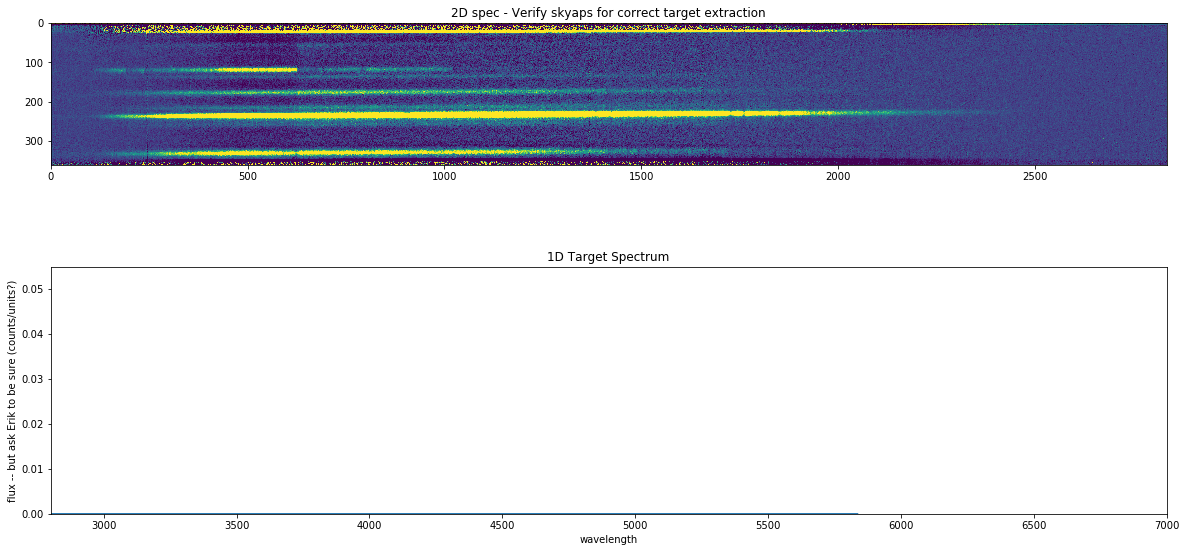

In [148]:
#naming files needed

#this one has more than one image tho....how to deal with? or do i have to? - non-SAGA
targetID_blue10 = 'M-01-04' #PROBLEM THIS TARGET ISNT IN 1.0" ONLY 1.5"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
skyaps_blue10 = [(270,310), (30, 190)]#sky aperatures-part to subtract sky lines from in spatial direction 
#skyaps == A list of 2-tuples (lower, upper) or slices, specifying the sections along the spatial direction to define the sky.
#aka sections above & below target spec to base subtraction on

#(15,80),(150,215) #old skyaps
#(264,300), (140, 155) #eriks skyaps

flux_blue10, unc = sky_subtract(targetID_blue10,skyaps_blue10,ds_blue10,all_side_files_blue10,atlasfiles_blue10)

print('why is there negative and why are there so many objects in the field??')

### Red (1.0") skysubtract

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


5
choose 2D spec for redside
this is beginning value of target spec extraction: 340
this is end value of target spec extraction: 350
choose 1D target spec axis limits for redside


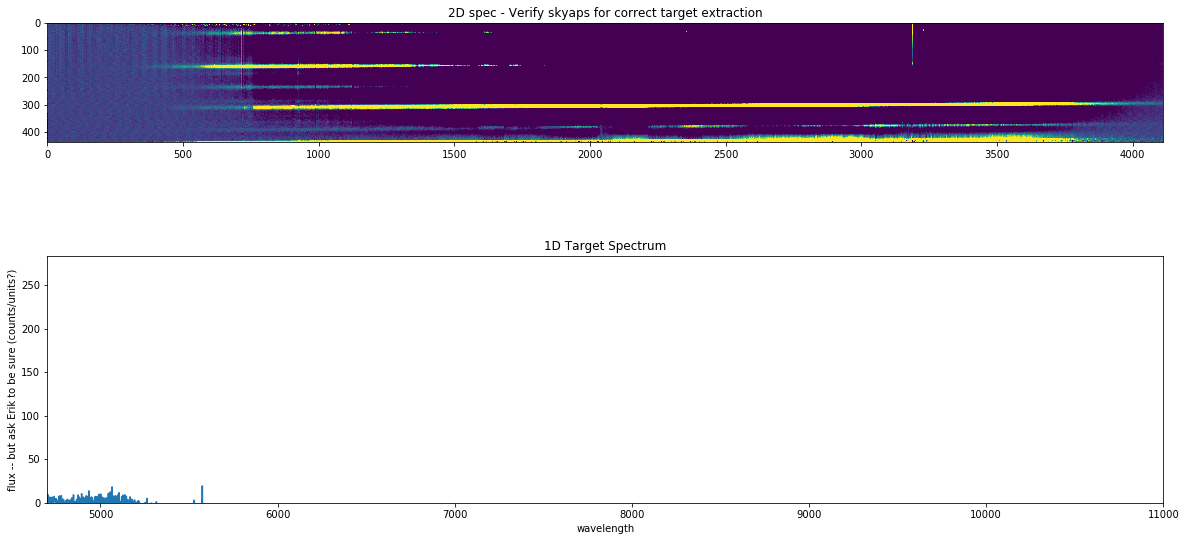

In [149]:
#naming files needed
targetID_red10 = 'M-01-04' #input name of target that uses 1.0"
skyaps_red10 = [(280,310),(380,410)]#sky aperatures-part to subtract sky lines from in spatial direction 

#(15,80),(150,215) #good for blue side
#(280,310),(380,410) #good for red side

flux_red10, unc = sky_subtract(targetID_red10,skyaps_red10,ds_red10,all_side_files_red10,atlasfiles_red10)

# OBrother_nospec
### Red (1.5") skysubtract

In [150]:
#naming files needed
targetID_red15_OB = 'OBrother_nospec'
skyaps_red15 = [(110,140),(190,220)]

#flux_red15_OB,unc = sky_subtract(targetID_red15_OB,skyaps_red15,ds_red15,all_side_files_red15,atlasfiles_red15)

#img[0] in combine_imgs() list index out of range. need to debug b/c shouldnt be aproblem

# __LEFT OFF HERE FIGUREING OUT WHY GOT ERROR__

# Ody_nospec

###  Red (1.5") skysubtract

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


3
choose 2D spec for redside
this is beginning value of target spec extraction: 330
this is end value of target spec extraction: 350
choose 1D target spec axis limits for redside


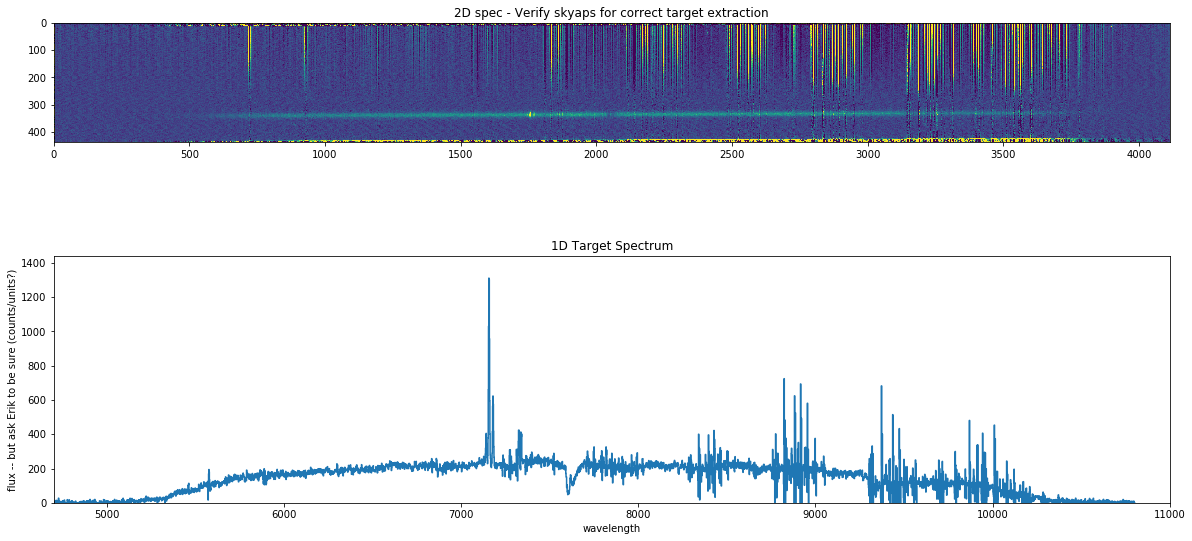

In [151]:
#naming files needed
targetID_red15 = 'Ody_nospec'
skyaps_red15 = [(270,310),(380,410)]

flux_red15,unc = sky_subtract(targetID_red15,skyaps_red15,ds_red15,all_side_files_red15,atlasfiles_red15)
plt.savefig('red1andahalf_skysubtracted_Ody_nospec.pdf', format='pdf', dpi=1200)



(0, 1441.8323928177338)

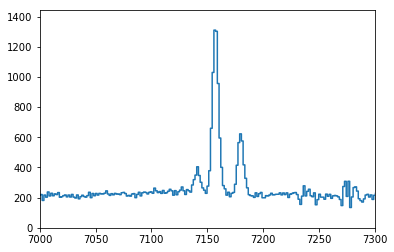

In [152]:
#zooming in on a peak to see if similar to eriks

wl = ds_red15.pixtowl(np.arange(len(flux_red15)))
plt.step(wl, flux_red15)
plt.xlim(7000, 7300)
plt.ylim(0, plt.ylim()[-1])


/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


lessons learned: target ~ 20 in spatial dimension; 


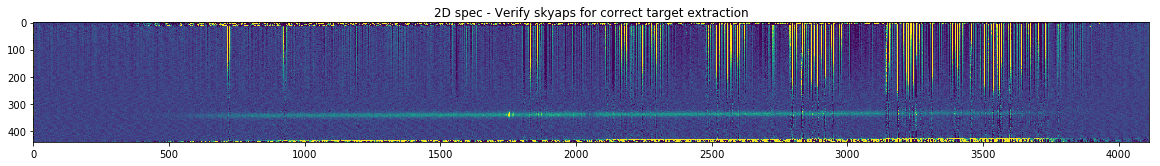

In [153]:
#playing with sky subtract window to get better skyaps for target extraction
##need to think of how to better account for diff target locations refine extraction algorithm based on skyaps

rskyaps=[(280,310),(380,410)]

rflats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat',all_side_files_red15)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
rnfl = reduce_dblspec.create_normalized_flat(rflats)
    
header_red15 = atlasfiles_red15[0].header    


    
    #locating all files w/ the target & flat/overscan subt
rspecs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(rnfl) 
          for fn in reduce_dblspec.find_all_obj(targetID_red15,all_side_files_red15)]
    #stacking all that data for specific target-help increase s/n 
rcomb = reduce_dblspec.combine_imgs(rspecs)
    
    #plotting 2D to get skyaps right around the target
plt.figure(figsize=(20,40)) #setting up fig size
rsubimg, models = rcomb.subtract_sky(rskyaps, skymodel=modeling.models.Linear1D(1,0))
plt.title('2D spec - Verify skyaps for correct target extraction')

rsubimg.show_image(transpose=False,vmax=40,vmin=-10)
#plt.xlim(1500,2000)
#plt.ylim(315,380)

print('lessons learned: target ~ 20 in spatial dimension; ')

### Blue (1.5") skysubtract

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


3
choose 2D spec for blueside
this is beginning value of target spec extraction: 85
this is end value of target spec extraction: 105
choose 1D target spec axis limits for blueside
WHY IS THERE NEGATIVE??


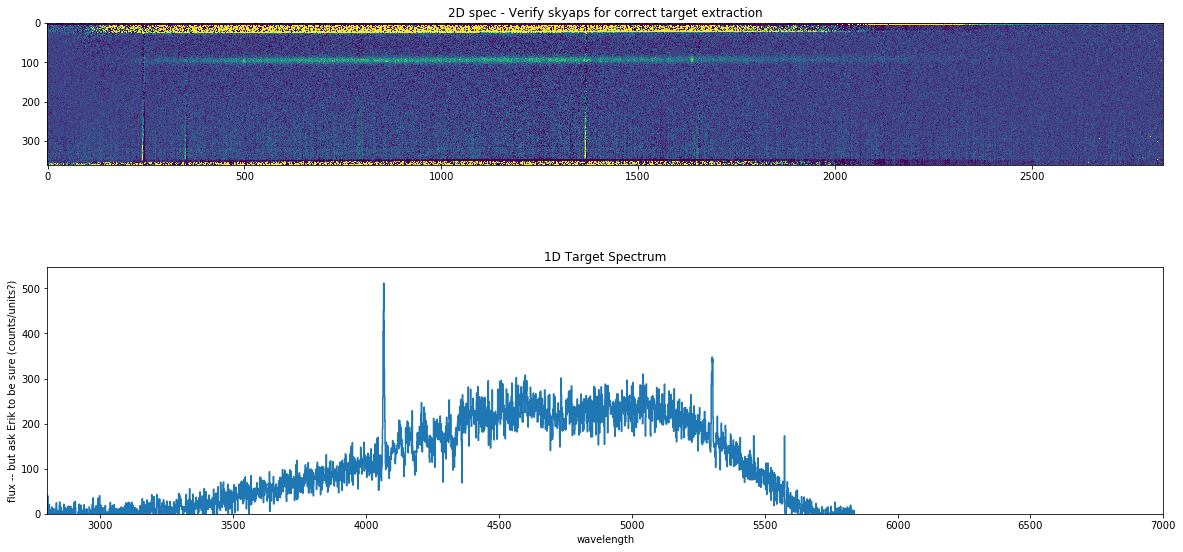

In [154]:
#naming files needed
targetID_blue15 = 'Ody_nospec'
skyaps_blue15 = [(25,80),(135,215)]

flux_blue15,unc_blue15 = sky_subtract(targetID_blue15,skyaps_blue15,ds_blue15,all_side_files_blue15,atlasfiles_blue15)

print('WHY IS THERE NEGATIVE??')

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


lessons learned: target ~ 20 in spatial dimension; 


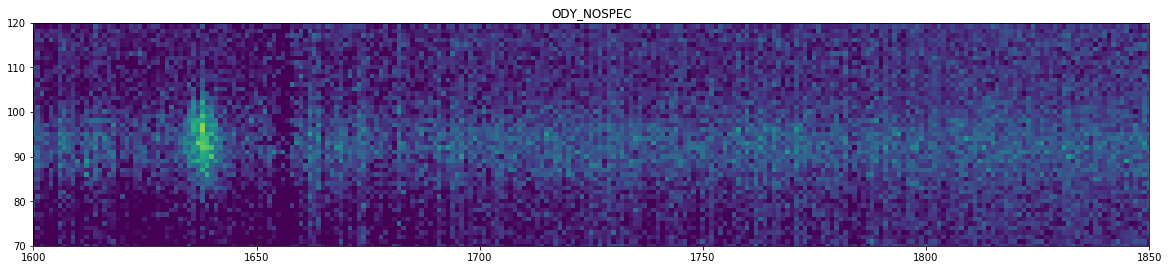

In [155]:
#playing with sky subtract window to get better skyaps for target extraction
##need to think of how to better account for diff target locations refine extraction algorithm based on skyaps

bskyaps = [(15,80),(150,215)]

plt.figure(figsize=(20,40)) #setting up fig size



bflats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat',all_side_files_blue15)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
bnfl = reduce_dblspec.create_normalized_flat(bflats)
    
header_blue15 = atlasfiles_blue15[0].header    


    
    #locating all files w/ the target & flat/overscan subt
bspecs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(bnfl) 
          for fn in reduce_dblspec.find_all_obj(targetID_blue15,all_side_files_blue15)]
    #stacking all that data for specific target-help increase s/n 
bcomb = reduce_dblspec.combine_imgs(bspecs)
    
    #plotting 2D to get skyaps right around the target
bsubimg, models = bcomb.subtract_sky(bskyaps, skymodel=modeling.models.Linear1D(1,0))
plt.title('2D spec - Verify skyaps for correct target extraction')

bsubimg.show_image(transpose=True,vmax=40,vmin=-10)
plt.xlim(1600,1850) #(1625,1645)--~1638 shows a strong emission line
plt.ylim(70,120)
#plt.figure(figsize=(20,10)) #setting up fig size
plt.title('ODY_NOSPEC')

print('lessons learned: target ~ 20 in spatial dimension; ')

### Combining red & blue sides Ody_nospec (1.5")

notice the solid horizontal extending past the blue side when it runs out of flux values,need to correct this


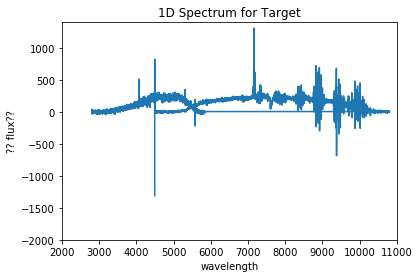

In [156]:
#combining using fcn

rb_flux = combine_red_blue(ds_red15,ds_blue15,flux_red15,flux_blue15)
plt.xlim(2000,11000)
plt.ylim(-2000,1400)
print('notice the solid horizontal extending past the blue side when it runs out of flux values,\
need to correct this')

whats up with the huge vertical line at the start of the overlap from the start 
of the red side?(left edge on this plot)


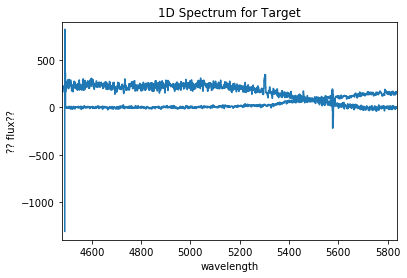

In [157]:
#zooming into overlap range

rb_flux = combine_red_blue(ds_red15,ds_blue15,flux_red15,flux_blue15)
#this is the overlap range +/- 10 on each side
plt.ylim(-1400,900)
plt.xlim(4479,5838)
##plt.xlim(4489,4491) #clearly shows red side begins ~4489.95
#plt.xlim(5834,5840) #can see last fluctuation at ~5837
print('whats up with the huge vertical line at the start of the overlap from the start', '\n'
'of the red side?(left edge on this plot)')

In [158]:
#for i in flux_red15: 
#        print (i) #beginning 2 vals are crazy low then high, not sure what caused this drastic fluctuation

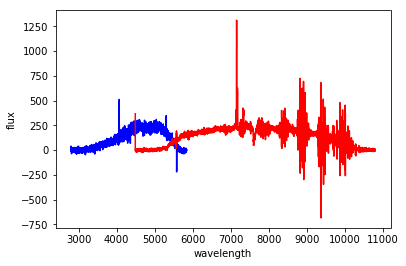

In [159]:
#seeing what the whole thing looks like w/o axis ranges
flux_red15_cut = flux_red15[2::]#because somethings wrong with first 2 vals, super negative then very high
#flux_blue15_cut = flux_blue15[10::]


#wl = np.append(ds_red15.pixtowl(np.arange(len(flux_red15_cut))), ds_blue15.pixtowl(np.arange(len(flux_blue15))))
wl = ds_blue15.pixtowl(np.arange(len(flux_blue15)))
wl_r = ds_red15.pixtowl(np.arange(len(flux_red15_cut)))
#red_and_blue_flux = np.append(flux_red15_cut,flux_blue15)
#plt.step(wl, red_and_blue_flux)
plt.step(wl, flux_blue15,'b')
plt.step(wl_r,flux_red15_cut,'r')
#plt.xlim(2000,7000)
plt.xlabel('wavelength')
plt.ylabel('flux')
#plt.axhline(0, color='k', ls=':') #this inserts a dotted line at the zero




#plt.xlim(7000, 7300)
#plt.ylim(0, plt.ylim()[-1])
#print('blue side looks crazy! BUT this is a complete/combined wavelength range 1D spectrum for target')
#for i in flux_blue15:
#    print(i)

#used below to print out fig for talk in the best ranges to show overlap
#these are best to zoom in on overlap region for talk
#plt.xlim(4000,6500)
#plt.ylim(0,600)
#print('is this okay to put in talk to illustrate overlap of red/blue?---yup')
#plt.savefig('overlap.pdf', format='pdf', dpi=1200)
print('idk why this is diff from BETTERmiddle notebook but it is and for talk going with, \
      graphs in BETTER')

In [160]:
#4.848 137 x  10-6 radians in 1" "

 # Why is horizontal line on blue side that extends to red side only there when i append blue and red???

In [161]:
#trying to add the overlap
from astropy.table import Table, join, vstack


wl_red15 = ds_red15.pixtowl(np.arange(len(flux_red15)))

wl_blue15 = ds_blue15.pixtowl(np.arange(len(flux_blue15)))
##plt.step(wl, flux_red15)
#plt.xlim(7000, 7300)
##plt.ylim(0, plt.ylim()[-1])

##for i in wl: 
##    print (i) #4489-10802 (wl_red15) #2805-5825 (wl_blue15)
#5837.05-2797.7 for blue15
#4489.95-10802.8 for red15
#so overlap is 4489-5837

red_overlap =[]
blue_overlap =[]
for i in wl_red15:
    if i <= 5837.05:
        red_overlap.append(i)
red_overlap #892 in length
#print (red_overlap) looks good
for i in wl_blue15:
    if i >= 4489.95:
        blue_overlap.append(i)
blue_overlap #1248 in length
#print (blue_overlap) ends might be funny but looks ok

##len(wl_red15) #4114
##len(wl_blue15) #2835
#len(flux_blue15)
t_red = Table([flux_red15, wl_red15], names=('Flux_red','WL'))
t_blue = Table([flux_blue15, wl_blue15],names=('Flux_blue','WL'))
t_red_overlap = t_red[0:892] #range of overlap
t_blue_overlap = t_blue[0:1247] #range of overlap #why different lengths of overlap? diff platescales??
t_red_cut = t_red[893::] #excludes overlap values
t_blue_cut = t_blue[1248::] #excludes overlap values
wl_red = (t_red_cut['WL'])
wl_blue = (t_blue_cut['WL'])


#cutting out overlaps
overlaps = vstack([t_red_overlap, t_blue_overlap])
overlaps['Flux_blue'].fill_value = 0.0
overlaps['Flux_red'].fill_value = 0.0
overlaps = overlaps.filled()
overlaps.sort('WL')

''' 
#this isnt right but was an attempt
liw2 = []
liw = overlaps['WL']
for idx, elem in enumerate(liw):
        thiselem = elem
        nextelem = liw[(idx + 1) % len(liw)]
          #  for i,e in enumerate(fl):
        if (thiselem - nextelem) < 0.5: #if wl's are this close
            newelem = (thiselem + nextelem)/2 #averageing the wl
        else:
            newelem = thiselem #if theyre not close enough just leave alone
        liw2.append(newelem) #giving a new wl


overlaps['test'] = liw2 #this isnt what i want b/c if averaged it doesnt skip the 
#next iteration so end with same length list

overlaps

'''

#overlaps['Flux_rb'] = (overlaps['Flux_red'] + overlaps['Flux_blue'])
#wl_overlap = (overlaps['WL'])





#len(wl_overlap) #only one merged

#putting red/overlap/blue into one table
#tall = Table()

##Flux_1 = np.append(t_red_cut['Flux_red'],overlaps['Flux_rb'])
##Flux = np.append(Flux_1, t_blue_cut['Flux_blue'])

#below shows that none of the wl's match exactly...so how to add?
#mergedata=(join(t_red_overlap, t_blue_overlap, keys=['WL']))
#mergedata

##wl_1 = np.append(wl_red,wl_overlap) #,wl_blue) #can only append 2 at a time
##wl = np.append(wl_blue,wl_1)
##plt.step(wl,Flux)
##plt.xlim(4450,4550)

" \n#this isnt right but was an attempt\nliw2 = []\nliw = overlaps['WL']\nfor idx, elem in enumerate(liw):\n        thiselem = elem\n        nextelem = liw[(idx + 1) % len(liw)]\n          #  for i,e in enumerate(fl):\n        if (thiselem - nextelem) < 0.5: #if wl's are this close\n            newelem = (thiselem + nextelem)/2 #averageing the wl\n        else:\n            newelem = thiselem #if theyre not close enough just leave alone\n        liw2.append(newelem) #giving a new wl\n\n\noverlaps['test'] = liw2 #this isnt what i want b/c if averaged it doesnt skip the \n#next iteration so end with same length list\n\noverlaps\n\n"

In [162]:
##table = Table([Flux, wl], names=('flux','wl'))
#for i in table['wl']:
 ##   print(i) #5838-
    
#liw = [0, 1, 2, 3]
#fl = [7,5,3,8]
#liw2 = []

#for idx, elem in enumerate(liw):
 #       thiselem = elem
  #      nextelem = liw[(idx + 1) % len(liw)]
   #         for i,e in enumerate(fl):
    #            if (thiselem - nextelem) <1:
     #               newelem = (thiselem + nextelem)/2 #averageing the wl
      #              liw2.append(newelem) #giving a new wl
                    
            
#li2

''' 
added = []
for i in overlaps['WL']:
        if (i - [i+1]) < 0.5:
            new_wl = (i + [i+1])/2
            
            added.append(new_wl)
overlaps['wl'] = new_wl
overlaps
''' 

" \nadded = []\nfor i in overlaps['WL']:\n        if (i - [i+1]) < 0.5:\n            new_wl = (i + [i+1])/2\n            \n            added.append(new_wl)\noverlaps['wl'] = new_wl\noverlaps\n"

good these look the same except overlap but that looks like addition so its all good!


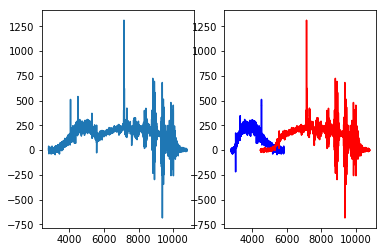

In [163]:
#trying adding again now that dont need to be sooo percise about wl...just want to visualize

f,(ax1,ax2) = plt.subplots(1,2)
#wl_red15 = ds_red15.pixtowl(np.arange(len(flux_red15)))
#wl_blue15 = ds_blue15.pixtowl(np.arange(len(flux_blue15)))
wl_blue15=wl_blue15[::-1] #this reverses the array to become increasing order
flux_blue15=flux_blue15[::-1] #need to also reverse this so associated vals agree w/ wl
flux_red15=flux_red15[2::] #chops off extreme val -1310.395.. & second extreme +1000 val
wl_red15=wl_red15[2::] #matched flux chop

wl_both = np.concatenate([wl_red15, wl_blue15])
wl_both = np.sort(wl_both)
##for i in wl_both:
 ##   print(i) #wl range is 2797.77..-10802.81
    
rspec = np.interp(wl_both,wl_red15,flux_red15,left=0) #need to do so doesnt repeat first val
#for i in rspec:
#    print(i) #no order these give random fluxes, good
#len(rspec) #6949
#len(wl_both) #6949
#len(wl_red15) #4114

bspec = np.interp(wl_both,wl_blue15,flux_blue15,right=0) #need so doesnt repeat last val
#for i in bspec:
#    print(i) #something wrong after 1st val of 5... EVERY val is identical(15.518)
#len(bspec) #6949
#len(wl_blue15) #2835
#for i in wl_blue15:#5837.05 - 2797.77
#    print(i) #heres the problem, interp needs in ascending order, currently decreasing

rbspec = rspec + bspec
#brspec = bspec + rspec
#plt.plot(wl_both, brspec) #this gives same blue side const val,,,weird
ax1.plot(wl_both,rbspec)#,color='g') #very crazy, if change to black get blue const val prob but
#if its green or blue theres no problem...
#plt.xlim(4000,6500) #cant zoom in b/c same problem above. WTF



#plotting original again for comparison
flux_red15_cut = flux_red15[2::]
wl = ds_blue15.pixtowl(np.arange(len(flux_blue15)))
wl_r = ds_red15.pixtowl(np.arange(len(flux_red15_cut)))
ax2.step(wl, flux_blue15,'b')
ax2.step(wl_r,flux_red15_cut,'r')
print('good these look the same except overlap but that looks like addition so its all good!')

In [164]:
#rbspec[1587:1600] #negative shift begins at 1588 this is near end of red side, try 
#cutting off edge w/ extreme vals
##for i in rspec:#end val keeps messing up and repeating even if not extreme
##    print (i) #first alot of vals are teh same -1310.395...until red chop of first 2 vals
for i in wl_both: #empty spot shows at [2088] but only when printed in this way so np?
    print (i)
#flux_red15[1::] #this chops off 1st extreme val of -1310.395...
#len(rspec) #6946
#len(wl_both) #6946
#len(wl_red15) #4114 now 4111 why chopped 3 not 2?
#len(flux_red15) #4111


2797.775653
2798.80180994
2799.8280411
2800.85434645
2801.88072593
2802.9071795
2803.93370712
2804.96030875
2805.98698434
2807.01373384
2808.04055722
2809.06745442
2810.09442541
2811.12147014
2812.14858856
2813.17578064
2814.20304633
2815.23038558
2816.25779835
2817.28528459
2818.31284427
2819.34047734
2820.36818375
2821.39596346
2822.42381643
2823.45174261
2824.47974196
2825.50781443
2826.53595998
2827.56417857
2828.59247015
2829.62083467
2830.64927211
2831.6777824
2832.70636551
2833.73502138
2834.76374999
2835.79255128
2836.82142521
2837.85037174
2838.87939082
2839.90848241
2840.93764646
2841.96688292
2842.99619177
2844.02557295
2845.05502641
2846.08455212
2847.11415003
2848.14382009
2849.17356227
2850.20337651
2851.23326278
2852.26322102
2853.2932512
2854.32335328
2855.3535272
2856.38377292
2857.41409041
2858.4444796
2859.47494047
2860.50547297
2861.53607705
2862.56675267
2863.59749979
2864.62831836
2865.65920833
2866.69016967
2867.72120232
2868.75230626
2869.78348142
2870.81472777


4770.2072045
4770.38632539
4771.29543083
4771.88909178
4772.38365022
4773.3918907
4773.47186261
4774.56006796
4774.89472214
4775.64826624
4776.39758609
4776.73645739
4777.82464137
4777.90048254
4778.91281814
4779.40341148
4780.00098765
4780.90637289
4781.08914986
4782.17730473
4782.40936676
4783.26545221
4783.91239309
4784.35359226
4785.41545185
4785.44172483
4786.52984988
4786.91854304
4787.61796737
4788.42166665
4788.70607725
4789.79417947
4789.92482266
4790.882274
4791.42801106
4791.97036079
4792.93123184
4793.05843979
4794.14651097
4794.43448499
4795.23457427
4795.9377705
4796.32262966
4797.41067708
4797.44108835
4798.4987165
4798.94443854
4799.58674787
4800.44782105
4800.67477115
4801.76278629
4801.95123587
4802.85079326
4803.45468299
4803.93879199
4804.95816239
4805.02678246
4806.11476462
4806.46167407
4807.20273842
4807.96521801
4808.29070381
4809.37866077
4809.46879421
4810.46660923
4810.97240264
4811.55454916
4812.4760433
4812.64248051
4813.73040325
4813.97971618
4814.81831732

5274.04736456
5274.74996876
5275.56034524
5275.83021532
5276.91043445
5277.07335455
5277.99062613
5278.58639246
5279.07079029
5280.09945897
5280.15092691
5281.23103594
5281.61255406
5282.31111732
5283.12567773
5283.39117103
5284.47119701
5284.63882995
5285.55119522
5286.15201073
5286.63116562
5287.66522004
5287.71110816
5288.7910228
5289.17845787
5289.87090949
5290.69172422
5290.95076819
5292.03059886
5292.20501907
5293.11040145
5293.71834241
5294.19017592
5295.23169423
5295.26992222
5296.34964032
5296.74507452
5297.42933016
5298.25848326
5298.5089917
5299.5886249
5299.77192044
5300.66822971
5301.28538605
5301.74780609
5302.79888009
5302.827354
5303.9068734
5304.31240253
5304.98636423
5305.82595337
5306.06582645
5307.14526003
5307.33953259
5308.22466491
5308.85314019
5309.30404105
5310.36677615
5310.38338841
5311.46270694
5311.88044045
5312.54199661
5313.3941331
5313.62125736
5314.70048915
5314.90785407
5315.77969194
5316.42160335
5316.85886568
5317.93538094
5317.93801033
5319.01712585

7134.54850904
7136.08766255
7137.6268304
7139.16601259
7140.70520909
7142.24441991
7143.78364503
7145.32288444
7146.86213812
7148.40140606
7149.94068826
7151.4799847
7153.01929537
7154.55862025
7156.09795934
7157.63731263
7159.17668009
7160.71606173
7162.25545752
7163.79486746
7165.33429154
7166.87372974
7168.41318205
7169.95264846
7171.49212896
7173.03162354
7174.57113218
7176.11065488
7177.65019161
7179.18974238
7180.72930716
7182.26888595
7183.80847873
7185.3480855
7186.88770624
7188.42734094
7189.96698958
7191.50665216
7193.04632867
7194.58601909
7196.12572341
7197.66544161
7199.2051737
7200.74491965
7202.28467945
7203.8244531
7205.36424058
7206.90404187
7208.44385698
7209.98368588
7211.52352856
7213.06338501
7214.60325523
7216.14313919
7217.68303689
7219.22294831
7220.76287345
7222.30281229
7223.84276482
7225.38273102
7226.9227109
7228.46270443
7230.0027116
7231.5427324
7233.08276682
7234.62281485
7236.16287648
7237.70295169
7239.24304047
7240.78314281
7242.32325871
7243.86338814


In [165]:
#len(wl_blue15) #2835
#len(wl_red15) #4111 so total is 6946
#wl_both[2080:2091]
err = Table([rbspec,wl_both], names=('flux','wl'))
err[1590:1595] # constant val begins with [1591]--1592 is last real val

<Table length=5>
     flux           wl     
   float64       float64   
------------- -------------
541.072544054 4492.94683776
384.700671978 4493.69434912
261.466487452 4494.44338396
284.016867048  4494.7829147
206.318817645 4495.87148452

In [166]:
#testing interp with random data

##inject = [0,10,20,25,35,45,55,65,75,80,90,100]
inject = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
x=[1,2,3,4,5,6,7,8,9,10]
y=[10,20,30,40,50,60,70,80,90,100]
##x = [0,10,20,30,40,50,60]
##y = [1,2,3,4,5,6,7]
see = np.interp(inject,x,y,right=0)
#see #array([ 1. ,  2. ,  3. ,  3.5,  4.5,  5.5,  6.5,  7.5,  0. ,  0. ,  0. ])
##x1 = [58, 68, 78, 80, 90,100,110]
##y1 = [5.8,6.8,7.8,8.8,9, 10, 11]
x1=[5,6,7,8,9,10,11,12,13,14,15]
y1=[50,60,70,80,90,100,110,120,130,140,150]
see1= np.interp(inject,x1,y1,left=0)
#see1#array([  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   6.5,   7.5,
         #8.8,   9. ,  10. ])
#seems these both chop off the last value tho
plus = see + see1
plus

array([  10.,   20.,   30.,   40.,  100.,  120.,  140.,  160.,  180.,
        200.,  110.,  120.,  130.,  140.,  150.])

where's the horizontal line from the blue side like in earlier versions?!?


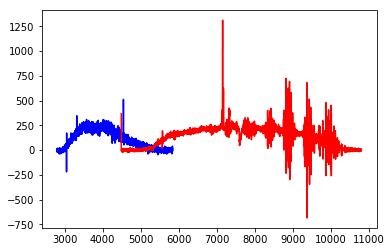

In [167]:
#exploring overlap

wl_blue = ds_blue15.pixtowl(np.arange(len(flux_blue15)))
wl_red = ds_red15.pixtowl(np.arange(len(flux_red15)))

plt.step(wl_blue,flux_blue15,'b')
plt.step(wl_red, flux_red15,'r')
print("where's the horizontal line from the blue side like in earlier versions?!?")

To Do List:
    1. fix combine spec b/c wavelenght ranges overlap
    2. fix 1D extraction being based on skyaps...need to generalize more based on target location, +/- could reverse
    3. run for other targets

In [168]:
#testing ways to combine spec sides --can prob delete, used when making combine_red_blue()

#testing
#print('red',len(flux_red15))
#print('blue', len(flux_blue15))
#print('rb:',len(red_and_blue_flux))

#wl_rb = np.append(ds_red15.pixtowl(np.arange(len(flux_red15))), ds_blue15.pixtowl(np.arange(len(flux_blue15))))
#print('red',len(ds_red15.pixtowl(np.arange(len(flux_red15)))))
#print('blue', len(ds_blue15.pixtowl(np.arange(len(flux_blue15)))))
#print('rb:',len(wl_rb))

## trying a trace with a specific target first then generalize into a fcn

In [169]:
#doing blue 1.5" first

#all_side_files_blue15 = '20170518/blue*.fits' #blueside
atlasfiles = fits.open('fear.fits') #NOAO atlas #blueside
arcfiles_blue15 = '20170518/blue0018.fits'

blue_flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat','20170518/blue*.fits')[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
blue_nfl = reduce_dblspec.create_normalized_flat(blue_flats)
    
header = atlasfiles[0].header    


    
    #locating all files w/ the target & flat/overscan subt
blue_specs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(blue_nfl) 
          for fn in reduce_dblspec.find_all_obj('Ody_nospec','20170518/blue*.fits')]
    
    
#print(len(blue_specs)) #3


    
    
    #stacking all that data for specific target-help increase s/n 
blue_comb = reduce_dblspec.combine_imgs(blue_specs)

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


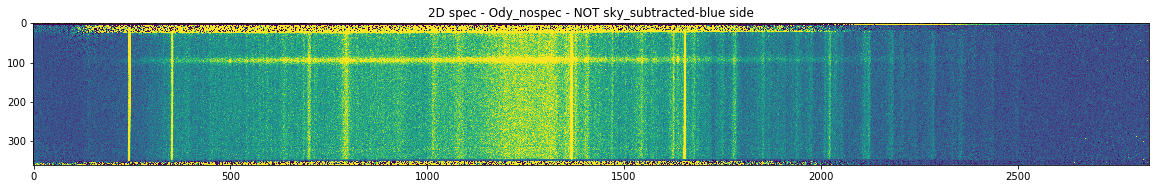

In [170]:
#quick try to use above defs to get UNsky-subtracted image -this isnt that pretty gonna try red side to match talk
plt.figure(figsize=(20,10)) #setting up fig size
#subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0))
plt.subplot(211)
plt.title('2D spec - Ody_nospec - NOT sky_subtracted-blue side')

#subimg.show_image(transpose=True,vmax=40,vmin=-10)
blue_comb.show_image(transpose=True,vmax=40,vmin=-10)

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


this worked good! - used in talk


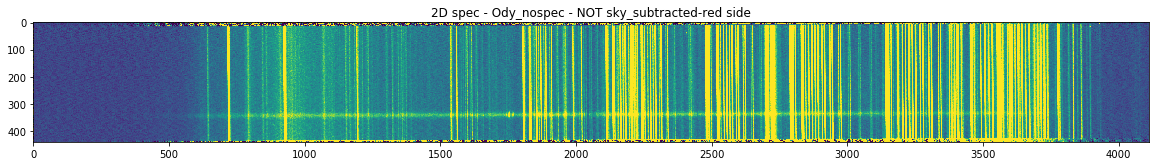

In [171]:
#doing un-sky subtraction again for red side this time

atlasfiles = fits.open('henear.fits') #NOAO atlas #redside
arcfiles_red15 = '20170518/red0017.fits'

red_flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat','20170518/red*.fits')[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
red_nfl = reduce_dblspec.create_normalized_flat(red_flats)
    
header = atlasfiles[0].header    


    
    #locating all files w/ the target & flat/overscan subt
red_specs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(red_nfl) 
          for fn in reduce_dblspec.find_all_obj('Ody_nospec','20170518/red*.fits')]

    
#print(len(blue_specs)) #3


    
    
    #stacking all that data for specific target-help increase s/n 
red_comb = reduce_dblspec.combine_imgs(red_specs)

plt.figure(figsize=(20,40)) #setting up fig size
#subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0))
plt.subplot(211)
plt.title('2D spec - Ody_nospec - NOT sky_subtracted-red side')

#subimg.show_image(transpose=True,vmax=40,vmin=-10)
red_comb.show_image(transpose=False,vmax=40,vmin=-10)
print('this worked good! - used in talk')

In [172]:
#checking data structure

#for i in blue_comb.data:
#    print(i)

wl_blue = ds_blue15.pixtowl(np.arange(len(blue_comb.data)))
trace_table = Table([blue_comb.data,wl_blue],names=('data-"flux"','wl'))
#len(trace_table['data-"flux"'][0]) #360
#len(blue_comb.data[0]) #360
print('okay this tells me that for each wl the data-"flux" contains all the counts per pixel in that wl column-good!')


okay this tells me that for each wl the data-"flux" contains all the counts per pixel in that wl column-good!


idk about those first 2 vals tho, major fluctuation might give problems-actually might give problems at both edges


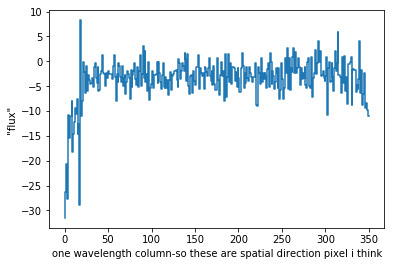

In [173]:
#plotting one wl column of 'flux'

#print(blue_comb.data[0])
#print(blue_comb.data[0][4:-5]) #this removes first 4 vals & last 5 b/c theyre 
#huge fluctuations e+02 at edges so 'bad'data neways, 
#can put back in later but out to make gaussian fitting easier now

plt.step(np.arange(len(blue_comb.data[0][4:-5])),blue_comb.data[0][4:-5])
plt.ylabel('"flux"')
plt.xlabel('one wavelength column-so these are spatial direction pixel i think')
print('idk about those first 2 vals tho, major fluctuation might give problems-actually might give problems at both edges')

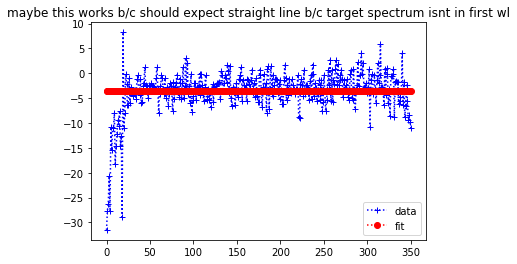

In [174]:
#fitting gaussian line to this wl column above-found code on stack overflow
#len(blue_comb.data[0][4:-5]) #351

import pylab as plb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

x = ar(range(351))
y = blue_comb.data[0][4:-5]

n = len(x)                          #the number of data
mean = sum(x*y)/n                   #note this correction
sigma = sum(y*(x-mean)**2)/n        #note this correction

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[max(y),mean,sigma])

plt.plot(x,y,'b+:',label='data') #flux per pix in wl column
plt.plot(x,gaus(x,*popt),'ro:',label='fit')
plt.legend()
plt.title('maybe this works b/c should expect straight line b/c target spectrum isnt in first wl')
plt.show()


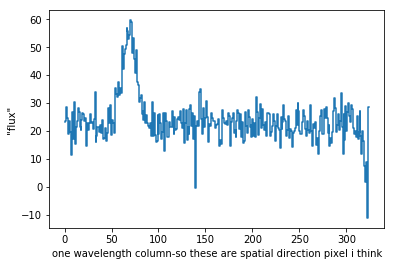

In [175]:
#trying again with a wl column galaxy should be in! 1638 wl should be a strong emission line to get a good fit

#trace_table['data-"flux"'][1638] #all vals look high but gonna plot n see

plt.step(np.arange(len(blue_comb.data[1638][25:-10])),blue_comb.data[1638][25:-10]) #cut off some to see target bump better
plt.ylabel('"flux"')
plt.xlabel('one wavelength column-so these are spatial direction pixel i think')

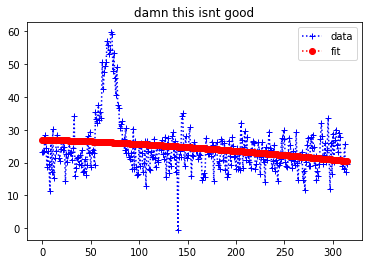

In [176]:
#trying to fit gaussian to above wl column - stack overflow code w/ corrections
x = ar(range(len(blue_comb.data[1638][25:-20]))) #cut off even more edges and now fit is a curve at least 
y = blue_comb.data[1638][25:-20]

n = len(x)                          #the number of data
mean = sum(x*y)/n                   
sigma = (sum(y*(x-mean)**2)/n)**0.5     

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[max(y),mean,sigma])

plt.plot(x,y,'b+:',label='data') #flux per pix in wl column
plt.plot(x,gaus(x,*popt),'ro:',label='fit')
plt.legend()
plt.title('damn this isnt good')
plt.show()

key lesson, need to combine gaussian with linear fit....but how to generalize this??


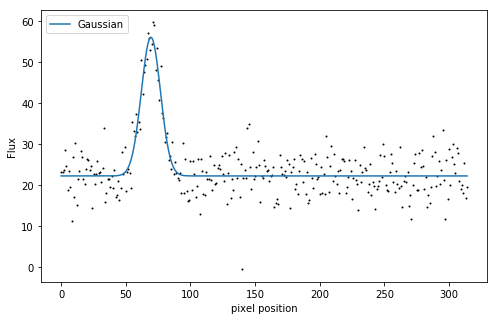

In [177]:
#another try using astropy codes
from astropy.modeling import models, fitting
# Fit the data using a Gaussian

y = blue_comb.data[1638][25:-20]
x =ar(range(len(blue_comb.data[1638][25:-20])))
g_init = models.Gaussian1D(amplitude=100., mean=60., stddev=10.) + modeling.models.Const1D(20)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)


plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko',markersize=1)
plt.plot(x, g(x), label='Gaussian')
plt.xlabel('pixel position')
plt.ylabel('Flux')
plt.title('')
plt.legend(loc=2)
print('key lesson, need to combine gaussian with linear fit....but how to generalize this??')

In [178]:
#need this for generalizing below
def mean(data):
    average = sum(data)/len(data)
    return(average)





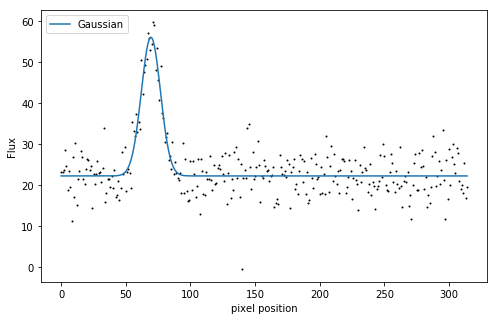

In [179]:
#trying to generalize my success above

y = blue_comb.data[1638][25:-20]
x =ar(range(len(blue_comb.data[1638][25:-20])))




#come back and work on how to generalize amplitude etc......


linear_const = mean(y)
linear_const #24.259828..not great b/c its including target so its higher than id like but still works...
#max(y) in this case is 59.6679, but this is the peak of the curve trying to fit so doing this should be ok
#cant use mean = linear_const or dont get right fit,,weird BUT max(y) works for some reason..
g_init = models.Gaussian1D(amplitude=max(y), mean=max(y), stddev=10.) + modeling.models.Const1D(linear_const)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)


plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko',markersize=1)
plt.plot(x, g(x), label='Gaussian')
plt.xlabel('pixel position')
plt.ylabel('Flux')
plt.legend(loc=2)

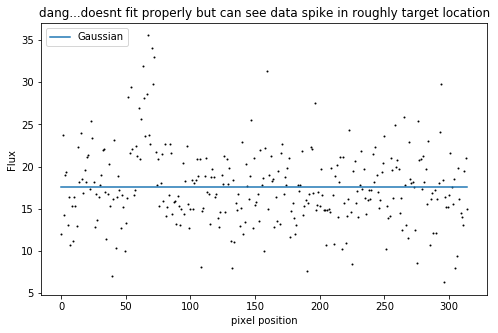

In [180]:
#trying above 'generalization' for other wls


#picking 1600 b/c its still close to the bright emission line in target so should still get gal spec
y = blue_comb.data[1600][25:-20]
x =ar(range(len(blue_comb.data[1600][25:-20])))




#come back and work on how to generalize amplitude etc......


linear_const = mean(y)
linear_const #24.259828..not great b/c its including target so its higher than id like but still works...
#max(y) in this case is 59.6679, but this is the peak of the curve trying to fit so doing this should be ok
#cant use mean = linear_const or dont get right fit,,weird BUT max(y) works for some reason..
g_init = models.Gaussian1D(amplitude=max(y), mean=max(y), stddev=10.) + modeling.models.Const1D(linear_const)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)


plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko',markersize=1)
plt.plot(x, g(x), label='Gaussian')
plt.xlabel('pixel position')
plt.ylabel('Flux')
plt.title('dang...doesnt fit properly but can see data spike in roughly target location')
plt.legend(loc=2)